In [64]:
import numpy as np
import sys
import math
import itertools
import matplotlib.pyplot as plt  
import networkx as nx
from heapq import heappop, heappush
from collections import deque

# Árbol Generador Mínimo

## 7.1 Introducción

Los algoritmos de Árbol Generador Mínimo (AGM) tienen como entrada un grafo pesado conexo y devuelven un subgrafo con todos los nodos y una subselección de los ejes cuya suma es la mínima posible. Esto implica que el subgrafo resultante sea un árbol, ya que no habrá ejes superfluos que formen ciclos.

Veremos 2 algoritmos _greedy_ que obtienen este árbol: **Kruskal** y **Prim**, que sólo difieren en el método utilizado para determinar que ejes deben ser incluídos en el AGM. Paso a paso irán agregando 1 eje al árbol hasta incluir todos los nodos del grafo original. Lo que estos algoritmos deben resolver es determinar que ejes son _safe_ para agregar al árbol. 

Un eje _safe_ es un eje que no rompe la propiedad constante en el _loop_ de estos algoritmos: a cada paso, el árbol que se va construyendo es un subgrafo del AGM. Es decir, los ejes que se agregan no se quitan, por lo que todo eje agregado debe ser uno de los ejes del AGM.

Cabe aclarar que si bien nos referimos a un AGM, éste puede no ser único y haber más de un AGM para 1 sólo grafo. Por ejemplo, es posible que para un mismo grafo, Kruskal y Prim devuelvan AGM distintos. Lo seguro es que la suma de los pesos de los ejes de ambos AGMs será idéntica, la mínima.

<img src="agm_1.png" alt="mm" style="width: 1200px;"/>

En la primer imagen se resaltan los ejes que pertenecen al AGM, cuya suma es 37, la mínima posible. En la segunda se ve un paso intermedio arbitrario en donde los vértices resaltados en negro ya pertenecen al recorte **S**. Los ejes resaltados fuera del corte son los ejes que pertenecerán al AGM y el eje `(c, d)` es denominado _light_ , por cruzar la frontera del corte ya resuelto (subgrafo del AGM), y este eje será _safe_ para agregar al árbol creciente. Notar también que el eje `(b, c)` será incluído en el AGM en lugar del `(a, h)`, y esto no es una necesidad. Existe un AGM alternativo donde este escenario se invierte.

Creemos un grafo como el de la figura para probar nuestros algoritmos:

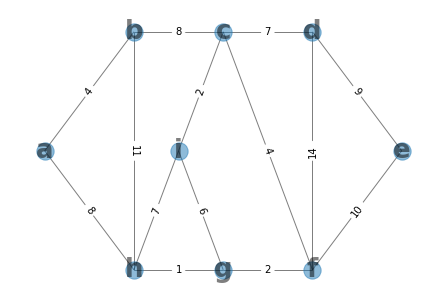

In [104]:
G = nx.Graph()
G.add_weighted_edges_from([("a", "b", 4), ("a", "h", 8), ("b", "h", 11), ("b", "c", 8), ("c", "i", 2), ("i", "h", 7), ("h", "g", 1),
("i", "g", 6), ("c", "f", 4), ("c", "d", 7), ("d", "f", 14), ("d", "e", 9), ("e", "f", 10), ("f", "g", 2) ])

pos = nx.spring_layout(G, seed=20)
pos["a"] = [-1, 0]
pos["b"] = [-.5, 1]
pos["c"] = [0, 1]
pos["d"] = [.5, 1]
pos["e"] = [1, 0]
pos["f"] = [.5, -1]
pos["g"] = [0, -1]
pos["h"] = [-.5, -1]
pos["i"] = [-.25, 0]

labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels = True, alpha = .5, font_size = 26, font_weight = 'bold')
plt = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

--------

## 7.2 Kruskal

In [100]:
def agm_kruskal(G):
    A = nx.Graph()
    bosque = nx.utils.UnionFind()

    ejes = G.edges(data=True)
    ejes = sorted(edges, key = lambda t: t[-1].get("weight", 1))

    for u, v, att in ejes:
        if bosque[u] != bosque[v]:
            A.add_weighted_edges_from([(u, v, att["weight"])])
            bosque.union(u, v)
    return A


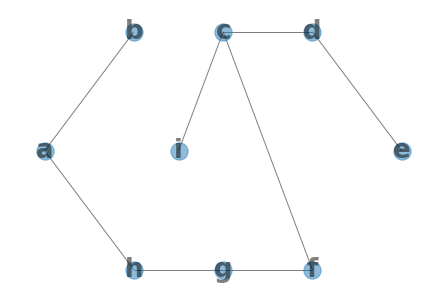

In [103]:
agm = agm_kruskal(G)
nx.draw(agm, pos, with_labels = True, alpha = .5, font_size = 26, font_weight = 'bold')

In [ ]:
def bfs(G, s):
    for v in G.nodes():
        G.nodes[v]["visitado"] = False
        G.nodes[v]["predecesor"] = False
        G.nodes[v]["distancia"] = np.inf
    G.nodes[s]["visitado"] = True
    G.nodes[s]["predecesor"] = False
    G.nodes[s]["distancia"] = 0
    cola = deque()
    cola.append(s)
    while len(cola) != 0:
        u = cola.pop()
        for v in G[u]:
            if G.nodes[v]["visitado"] == False:
                G.nodes[v]["visitado"] = True
                G.nodes[v]["distancia"] = G.nodes[u]["distancia"] + 1
                G.nodes[v]["predecesor"] = u
                cola.appendleft(v)

---

## Complejidad


$$
O(n  \log(m))
$$

## 7.3 Prim

$$ g_{ij} = 
 \begin{cases}
1, \qquad \text{si } G \text{ tiene una arista entre los vértices } i \text{ y } j
\newline
0, \qquad \text{si no}
\end{cases} $$

$$ G = 
\begin{bmatrix}
& 0  & 0  & 1  & 1  & \\
& 0  & 0  & 1  & 1  & \\
& 1  & 1  & 0  & 1  & \\
& 1  & 1  & 1  & 1  & \\
\end{bmatrix}$$

----

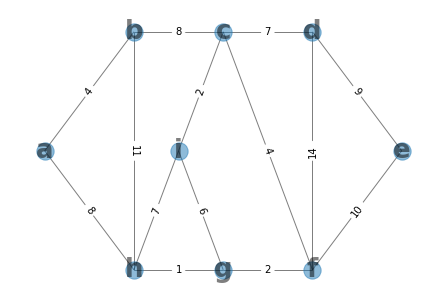

In [50]:
G = nx.Graph()
G.add_weighted_edges_from([("a", "b", 4), ("a", "h", 8), ("b", "h", 11), ("b", "c", 8), ("c", "i", 2), ("i", "h", 7), ("h", "g", 1),
("i", "g", 6), ("c", "f", 4), ("c", "d", 7), ("d", "f", 14), ("d", "e", 9), ("e", "f", 10), ("f", "g", 2) ])

pos = nx.spring_layout(G, seed=20)
pos["a"] = [-1, 0]
pos["b"] = [-.5, 1]
pos["c"] = [0, 1]
pos["d"] = [.5, 1]
pos["e"] = [1, 0]
pos["f"] = [.5, -1]
pos["g"] = [0, -1]
pos["h"] = [-.5, -1]
pos["i"] = [-.25, 0]

labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels = True, alpha = .5, font_size = 26, font_weight = 'bold')
plt = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [5]:
def bfs(G, s):
    for v in G.nodes():
        G.nodes[v]["visitado"] = False
        G.nodes[v]["predecesor"] = False
        G.nodes[v]["distancia"] = np.inf
    G.nodes[s]["visitado"] = True
    G.nodes[s]["predecesor"] = False
    G.nodes[s]["distancia"] = 0
    cola = deque()
    cola.append(s)
    while len(cola) != 0:
        u = cola.pop()
        for v in G[u]:
            if G.nodes[v]["visitado"] == False:
                G.nodes[v]["visitado"] = True
                G.nodes[v]["distancia"] = G.nodes[u]["distancia"] + 1
                G.nodes[v]["predecesor"] = u
                cola.appendleft(v)

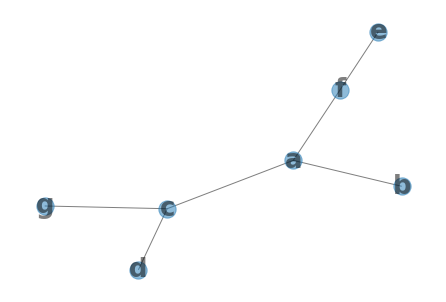

In [18]:
A = bfs_arbol(G, "a")
nx.draw(A, with_labels = True, alpha = .5, font_size = 26, font_weight = 'bold')

## 7. Conclusión

* Aprovechen esta notebook, jueguen **mucho** con BFS y DFS. Hagan sus propios grafos, predigan los árboles y atributos (`distancia` o `inicio` y `fin`) resultantes y comprueben sus predicciones.
* Leer del Cormen: **p(586-620)**

--------------------

### Contenidos a explicar durante la práctica

1. Implementaciones de las distintas representaciones de grafos
2.